In [6]:
!pip install sqlalchemy pyathena pandas

In [7]:
from pyathena import connect
import pandas as pd

In [8]:

# Define your AWS region and S3 location for Athena query results
region_name = "us-east-1"  # Change to your AWS region
s3_staging_dir = "s3://aws-glue-assets-253490795594-us-east-1/Unsaved/"  # Change this

# Establish connection to Athena
conn = connect(
    region_name=region_name,
    s3_staging_dir=s3_staging_dir
)
query = "SHOW DATABASES;"
df = pd.read_sql(query, conn)

print("Athena Databases:")
print(df)

/tmp/ipykernel_8003/3527251622.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Athena Databases:
        database_name
0             default
1  marketing_campaign
2          nursing_db
3             thyroid


In [9]:
query = 'select * from marketing_campaign.campaign_query'
df = pd.read_sql(query, conn)
print(df.head())

/tmp/ipykernel_8003/2905897267.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


   campaign_item_id advertising_platform channel_name  impressions  clicks  \
0              2733                DV360       Social         2634      44   
1              2733         Facebook Ads       Mobile          837       8   
2              2733         Facebook Ads       Social         2135      32   
3              2733         Facebook Ads        Video         2327      48   
4              2733           Google Ads       Mobile         1538      20   

    ctr  total_spent   cpc    cpm   roi  total_campaign_impressions  \
0  1.67        99.63  2.26  37.83  0.44                        9471   
1  0.96        14.06  1.76  16.80  0.57                        9471   
2  1.50       109.42  3.42  51.25  0.29                        9471   
3  2.06       115.21  2.40  49.51  0.42                        9471   
4  1.30        66.99  3.35  43.56  0.30                        9471   

   total_campaign_clicks  total_campaign_ctr  total_campaign_spent  \
0                    152          

In [22]:
# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

campaign_item_id              0
advertising_platform          0
channel_name                  0
impressions                   0
clicks                        0
ctr                           0
total_spent                   0
cpc                           0
cpm                           0
roi                           0
total_campaign_impressions    0
total_campaign_clicks         0
total_campaign_ctr            0
total_campaign_spent          0
total_campaign_cpc            0
total_campaign_cpm            0
total_campaign_roi            0
dtype: int64
       campaign_item_id    impressions        clicks          ctr  \
count       2169.000000    2169.000000   2169.000000  2169.000000   
mean        3187.893499   45868.917012   1764.122176     3.104269   
std          175.610475   57271.828729   3817.716012     4.168004   
min         2733.000000     541.000000      3.000000     0.320000   
25%         3102.000000    9549.000000    173.000000     1.290000   
50%         3171.000000   252

In [49]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ✅ Features and Target Variable
X = df.drop(['roi'], axis=1)  # Features (exclude the target)
y = df['roi']  # Target variable

# ✅ Preprocessing: One-Hot Encoding + Scaling
categorical_features = ['advertising_platform', 'channel_name']
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in categorical_features]

# Transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# ✅ Model Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Fit the Model
pipeline.fit(X_train, y_train)

# ✅ Make Predictions
y_pred = pipeline.predict(X_test)

# ✅ Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

print(f'Predicted ROI for new campaign: {y_pred[0]:.2f}')

# ✅ Feature Importance
importances = pipeline.named_steps['model'].feature_importances_
feature_names = numerical_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance)

Mean Squared Error: 0.5157771467281077
R2 Score: 0.978510142186343
Predicted ROI for new campaign: 4.19
                              Feature  Importance
4                         total_spent    0.405233
5                                 cpc    0.386822
6                                 cpm    0.150015
3                                 ctr    0.026106
18                channel_name_Mobile    0.005535
1                         impressions    0.005415
19                channel_name_Search    0.004923
11                 total_campaign_cpc    0.003683
2                              clicks    0.003429
8               total_campaign_clicks    0.002836
9                  total_campaign_ctr    0.002508
12                 total_campaign_cpm    0.002319
15  advertising_platform_Facebook Ads    0.000457
13                 total_campaign_roi    0.000222
0                    campaign_item_id    0.000207
17               channel_name_Display    0.000135
16    advertising_platform_Google Ads    0.000

In [53]:
# ✅ Simulate different CPC and Spend combinations
simulation_results = []

# Get current CPC and spend ranges from your dataset
cpc_min, cpc_max = df['cpc'].min() * 0.8, df['cpc'].max() * 1.2
spend_min, spend_max = df['total_spent'].min() * 0.8, df['total_spent'].max() * 1.2

# Generate ranges for simulation
cpc_range = np.linspace(cpc_min, cpc_max, 20)  # 20 variations of CPC
spend_range = np.linspace(spend_min, spend_max, 20)  # 20 variations of spend

# Include missing columns in the simulation with placeholder values
for cpc in cpc_range:
    for spend in spend_range:
        # Use average values for the other metrics
        simulated_data = pd.DataFrame([{
            'campaign_item_id': 9999,  # Placeholder ID
            'advertising_platform': 'Facebook Ads',  # Random platform for consistency
            'channel_name': 'Social',  # Random channel
            'impressions': df['impressions'].mean(),
            'clicks': df['clicks'].mean(),
            'ctr': df['ctr'].mean(),
            'total_spent': spend,
            'cpc': cpc,
            'cpm': df['cpm'].mean(),
            'roi': 0,  # Placeholder (since we will predict it)

            # Campaign-level metrics with placeholder averages
            'total_campaign_impressions': df['total_campaign_impressions'].mean(),
            'total_campaign_clicks': df['total_campaign_clicks'].mean(),
            'total_campaign_ctr': df['total_campaign_ctr'].mean(),
            'total_campaign_spent': df['total_campaign_spent'].mean(),
            'total_campaign_cpc': df['total_campaign_cpc'].mean(),
            'total_campaign_cpm': df['total_campaign_cpm'].mean(),
            'total_campaign_roi': df['total_campaign_roi'].mean()
        }])

        # Ensure same column order as the model
        simulated_data = simulated_data[df.columns]

        # Apply the same preprocessing steps
        simulated_transformed = pipeline.named_steps['preprocessor'].transform(simulated_data)

        # Predict ROI
        predicted_roi = pipeline.named_steps['model'].predict(simulated_transformed)[0]

        # Store results
        simulation_results.append({
            'cpc': cpc,
            'total_spent': spend,
            'predicted_roi': predicted_roi
        })

# Convert results to DataFrame
simulation_df = pd.DataFrame(simulation_results)


/tmp/ipykernel_8040/3391636361.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = simulation_df.pivot("cpc", "total_spent", "predicted_roi")


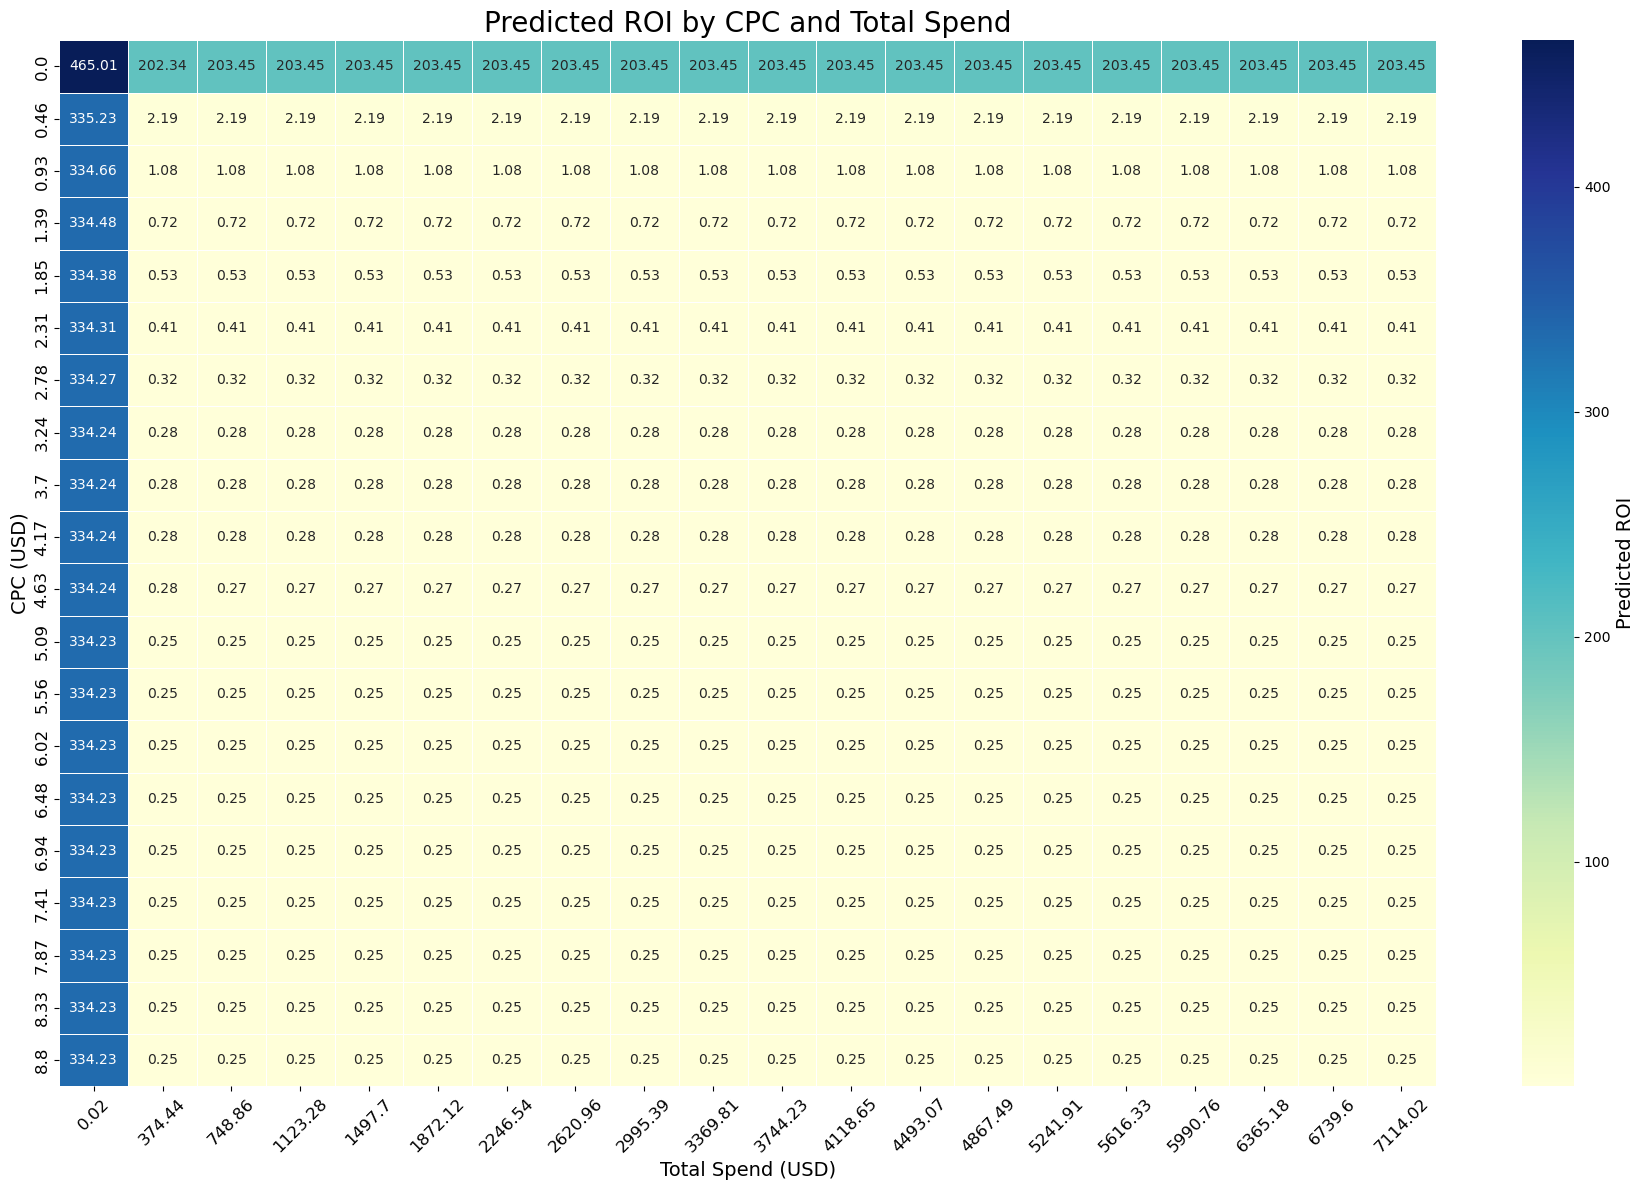

In [58]:

# ✅ Round all values to 2 decimal places
simulation_df = simulation_df.round(2)

# ✅ Create the plot
fig, ax = plt.subplots(figsize=(18, 12))  # Larger size to display all numbers

# Pivot the DataFrame for heatmap
pivot_df = simulation_df.pivot("cpc", "total_spent", "predicted_roi")

# ✅ Use heatmap with better formatting
heatmap = sns.heatmap(
    pivot_df, 
    annot=True, 
    fmt=".2f",           # Display 2 decimal places
    cmap="YlGnBu", 
    cbar=True, 
    annot_kws={"size": 10},  # Slightly smaller font for annotations
    linewidths=0.5,          # Add small grid lines for clarity
    square=False,            # Avoid squishing cells
    ax=ax
)

# ✅ Add labels and formatting
heatmap.collections[0].colorbar.set_label('Predicted ROI', fontsize=14)  # Color bar label
plt.title('Predicted ROI by CPC and Total Spend', fontsize=20)
plt.xlabel('Total Spend (USD)', fontsize=14)
plt.ylabel('CPC (USD)', fontsize=14)

# Adjust tick labels for better visibility
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# ✅ Ensure no clipping of labels
plt.tight_layout()

# Display the chart
plt.show()

/tmp/ipykernel_8040/1829722924.py:56: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = simulation_df.pivot("cpc", "total_spent", "predicted_roi")


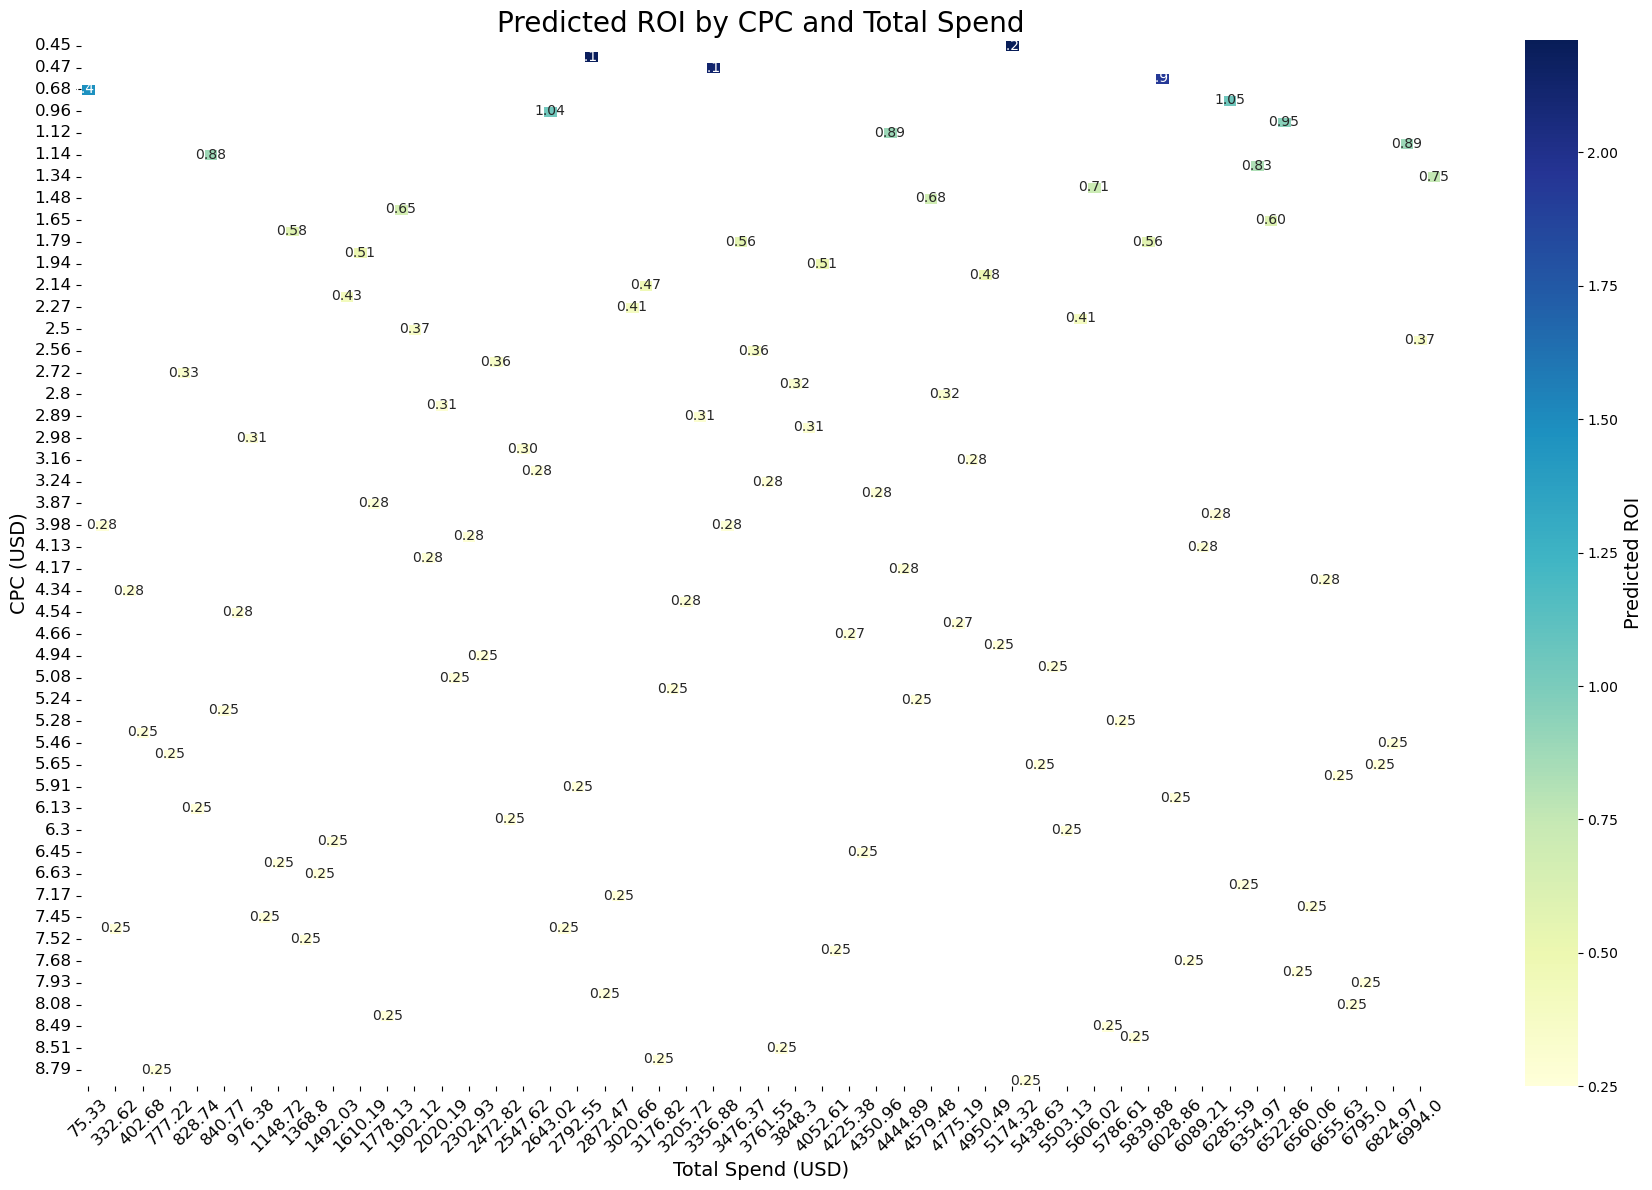

In [60]:
# Generate random values within the ranges for CPC and Spend
num_simulations = 100  # number of random simulations
cpc_range = np.random.uniform(cpc_min, cpc_max, num_simulations)  # Random CPC values
spend_range = np.random.uniform(spend_min, spend_max, num_simulations)  # Random Spend values

simulation_results = []
for cpc, spend in zip(cpc_range, spend_range):
    simulated_data = pd.DataFrame([{
        'campaign_item_id': 9999,
        'advertising_platform': 'Facebook Ads',
        'channel_name': 'Social',
        'impressions': df['impressions'].mean(),
        'clicks': df['clicks'].mean(),
        'ctr': df['ctr'].mean(),
        'total_spent': spend,
        'cpc': cpc,
        'cpm': df['cpm'].mean(),
        'roi': 0,  # Placeholder
        
        'total_campaign_impressions': df['total_campaign_impressions'].mean(),
        'total_campaign_clicks': df['total_campaign_clicks'].mean(),
        'total_campaign_ctr': df['total_campaign_ctr'].mean(),
        'total_campaign_spent': df['total_campaign_spent'].mean(),
        'total_campaign_cpc': df['total_campaign_cpc'].mean(),
        'total_campaign_cpm': df['total_campaign_cpm'].mean(),
        'total_campaign_roi': df['total_campaign_roi'].mean()
    }])

    # Ensure same column order as the model
    simulated_data = simulated_data[df.columns]

    # Apply preprocessing
    simulated_transformed = pipeline.named_steps['preprocessor'].transform(simulated_data)

    # Predict ROI
    predicted_roi = pipeline.named_steps['model'].predict(simulated_transformed)[0]

    # Store results
    simulation_results.append({
        'cpc': cpc,
        'total_spent': spend,
        'predicted_roi': predicted_roi
    })

# Convert results to DataFrame
simulation_df = pd.DataFrame(simulation_results)


# ✅ Round all values to 2 decimal places
simulation_df = simulation_df.round(2)

# ✅ Create the plot
fig, ax = plt.subplots(figsize=(18, 12))  # Larger size to display all numbers

# Pivot the DataFrame for heatmap
pivot_df = simulation_df.pivot("cpc", "total_spent", "predicted_roi")

# ✅ Use heatmap with better formatting
heatmap = sns.heatmap(
    pivot_df, 
    annot=True, 
    fmt=".2f",           # Display 2 decimal places
    cmap="YlGnBu", 
    cbar=True, 
    annot_kws={"size": 10},  # Slightly smaller font for annotations
    linewidths=0.5,          # Add small grid lines for clarity
    square=False,            # Avoid squishing cells
    ax=ax
)

# ✅ Add labels and formatting
heatmap.collections[0].colorbar.set_label('Predicted ROI', fontsize=14)  # Color bar label
plt.title('Predicted ROI by CPC and Total Spend', fontsize=20)
plt.xlabel('Total Spend (USD)', fontsize=14)
plt.ylabel('CPC (USD)', fontsize=14)

# Adjust tick labels for better visibility
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# ✅ Ensure no clipping of labels
plt.tight_layout()

# Display the chart
plt.show()

In [17]:
import pandas as pd
from scipy import stats


query = 'select * from marketing_campaign.campaign_query'
df = pd.read_sql(query, conn)

### ✅ 1. Significance Testing: Google Ads vs. Facebook Ads ROI
# Separate the data by platform
group_google = df[df['advertising_platform'] == 'Google Ads']['roi']
group_fb = df[df['advertising_platform'] == 'Facebook Ads']['roi']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(group_google, group_fb)

# Output the results
print("\n🔍 Significance Testing: Google Ads vs. Facebook Ads ROI")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Check for significance
if p_value < 0.05:
    print("✅ Statistically significant difference: Google Ads and Facebook Ads ROI are different.")
else:
    print("❌ No statistically significant difference: The difference in ROI could be due to chance.")


### 🚀 2. A/B Test: Comparing CPC Ranges and ROI
# Define CPC ranges
low_cpc = df[df['cpc'] <= 2.00]['roi']
high_cpc = df[df['cpc'] > 2.00]['roi']

# Perform the t-test for CPC ranges
t_stat_cpc, p_value_cpc = stats.ttest_ind(low_cpc, high_cpc)

# Output the results
print("\n🔍 A/B Test: Low CPC vs. High CPC ROI")
print(f"T-statistic: {t_stat_cpc}")
print(f"P-value: {p_value_cpc}")

# Check for significance
if p_value_cpc < 0.05:
    print("✅ Statistically significant difference: Low CPC yields better ROI.")
else:
    print("❌ No statistically significant difference: The difference between low and high CPC ROI could be due to chance.")


/tmp/ipykernel_8003/2338013076.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



🔍 Significance Testing: Google Ads vs. Facebook Ads ROI
T-statistic: 1.208289098744364
P-value: 0.227134327544035
❌ No statistically significant difference: The difference in ROI could be due to chance.

🔍 A/B Test: Low CPC vs. High CPC ROI
T-statistic: 1.678396020560806
P-value: 0.0934139990673836
❌ No statistically significant difference: The difference between low and high CPC ROI could be due to chance.


In [ ]:
import pandas as pd
from scipy import stats


query = 'select * from marketing_campaign.campaign_query'
df = pd.read_sql(query, conn)

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Assuming 'df' contains your data and has the columns 'roi' and 'advertising_platform'

# Visualize the distributions (histogram and boxplot) for Google Ads vs. Facebook Ads
google_roi = df[df['advertising_platform'] == 'Google Ads']['roi']
fb_roi = df[df['advertising_platform'] == 'Facebook Ads']['roi']

# Visualizing the distributions of ROI for Google Ads and Facebook Ads
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(google_roi, alpha=0.5, label='Google Ads ROI', color='blue', bins=30)
plt.hist(fb_roi, alpha=0.5, label='Facebook Ads ROI', color='red', bins=30)
plt.legend(loc='upper right')
plt.title('Histogram of ROI: Google Ads vs Facebook Ads')

plt.subplot(1, 2, 2)
plt.boxplot([google_roi, fb_roi], labels=['Google Ads', 'Facebook Ads'], vert=False)
plt.title('Boxplot of ROI: Google Ads vs Facebook Ads')
plt.show()

# Perform the t-test to see if there is a significant difference in ROI between Google Ads and Facebook Ads
t_stat, p_value = stats.ttest_ind(google_roi, fb_roi)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Check if the p-value is less than 0.05 (significance level)
if p_value < 0.05:
    print("Statistically significant difference: Google Ads and Facebook Ads ROI are different.")
else:
    print("No significant difference: The difference in ROI could be due to chance.")

# Check if the data is normally distributed before using the t-test (Shapiro-Wilk test)
google_shapiro = stats.shapiro(google_roi)
fb_shapiro = stats.shapiro(fb_roi)

print(f"Shapiro-Wilk Test p-value for Google Ads: {google_shapiro.pvalue}")
print(f"Shapiro-Wilk Test p-value for Facebook Ads: {fb_shapiro.pvalue}")

# If the data is not normal, use the Mann-Whitney U test (non-parametric test)
if google_shapiro.pvalue < 0.05 or fb_shapiro.pvalue < 0.05:
    print("Data is not normally distributed, applying Mann-Whitney U test...")
    u_stat, u_p_value = stats.mannwhitneyu(google_roi, fb_roi)
    print(f"Mann-Whitney U Statistic: {u_stat}, p-value: {u_p_value}")
    if u_p_value < 0.05:
        print("Statistically significant difference: Non-parametric test shows difference between Google Ads and Facebook Ads.")
    else:
        print("No significant difference: Non-parametric test shows no difference.")
else:
    print("Data is normally distributed, proceeding with the t-test.")

# Optional: Simulate increasing the sample size by adding random values (replace with actual larger dataset)
expanded_google_roi = np.random.normal(np.mean(google_roi), np.std(google_roi), 1000)  # Larger sample for Google Ads
expanded_fb_roi = np.random.normal(np.mean(fb_roi), np.std(fb_roi), 1000)  # Larger sample for Facebook Ads

# Perform the t-test again with a larger sample size
t_stat_expanded, p_value_expanded = stats.ttest_ind(expanded_google_roi, expanded_fb_roi)

print(f"With larger sample size - T-statistic: {t_stat_expanded}, P-value: {p_value_expanded}")

if p_value_expanded < 0.05:
    print("Statistically significant difference with larger sample size: Google Ads and Facebook Ads ROI are different.")
else:
    print("No significant difference with larger sample size: The difference in ROI could still be due to chance.")


In [15]:
from scipy.stats import ttest_ind
import pandas as pd

query = 'select * from marketing_campaign.time_campaign'
data = pd.read_sql(query, conn)

# Split into two groups
weekday_roi = data[data['weekday_cat'] == 'week_day']['roi']
weekend_roi = data[data['weekday_cat'] == 'week_end']['roi']

# Run t-test
t_stat, p_value = ttest_ind(weekday_roi, weekend_roi)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Statistically significant difference. Weekdays have higher ROI.")
else:
    print("No significant difference between weekdays and weekends.")


/tmp/ipykernel_8003/2061533217.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


T-statistic: 0.382516506719202, P-value: 0.7024442473082926
No significant difference between weekdays and weekends.
